# 8장. XGBoost 기본 학습기

In [1]:
!pip install -q --upgrade xgboost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
# 경고 끄기
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)

## gblinear 적용하기

### gblinear를 당뇨병 데이터셋에 적용하기

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor, XGBClassifier, XGBRFRegressor, XGBRFClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error as MSE

In [4]:
X, y = load_diabetes(return_X_y=True)

In [5]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

In [6]:
def regression_model(model):
    # 5폴드 교차 검증으로 음의 평균 제곱 오차를 구합니다.
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)

    # 제곱근을 계산합니다.
    rmse = (-scores)**0.5

    # 평균을 반환합니다.
    return rmse.mean()

In [7]:
regression_model(XGBRegressor(booster='gblinear'))

842.2757234013325

In [8]:
regression_model(LinearRegression())

55.50927267834349

In [9]:
regression_model(Lasso())

62.64900771743497

In [10]:
regression_model(Ridge())

58.83525077919003

In [11]:
regression_model(XGBRegressor(booster='gbtree'))

65.96608449382913

#### gblinear 그리드 서치

In [12]:
def grid_search(params, reg=XGBRegressor(booster='gblinear')):

    # GridSearchCV를 초기화합니다.
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    
    # X_train와 y_train에서 훈련합니다.
    grid_reg.fit(X, y)

    # 최상의 매개변수를 추출합니다.
    best_params = grid_reg.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)
    
    # 최상의 점수를 추출합니다.
    best_score = np.sqrt(-grid_reg.best_score_)

    # 최상의 점수를 출력합니다.
    print("최상의 점수:", best_score)

In [13]:
grid_search(params={'reg_alpha':[0.001, 0.01, 0.1, 0.5, 1, 5]})

최상의 매개변수: {'reg_alpha': 0.1}
최상의 점수: 55.72312297034484


In [14]:
grid_search(params={'reg_lambda':[0.001, 0.01, 0.1, 0.5, 1, 5]})

최상의 매개변수: {'reg_lambda': 0.001}
최상의 점수: 56.17163530032388


In [15]:
grid_search(params={'feature_selector':['shuffle']})

최상의 매개변수: {'feature_selector': 'shuffle'}
최상의 점수: 1357.8699867658001


In [16]:
grid_search(params={'feature_selector':['random', 'greedy', 'thrifty'], 
                    'updater':['coord_descent'] })

최상의 매개변수: {'feature_selector': 'thrifty', 'updater': 'coord_descent'}
최상의 점수: 55.48798105805444


In [17]:
grid_search(params={'feature_selector':['greedy', 'thrifty'], 
                    'updater':['coord_descent'], 'top_k':[3, 5, 7, 9]})

최상의 매개변수: {'feature_selector': 'thrifty', 'top_k': 3, 'updater': 'coord_descent'}
최상의 점수: 55.478623763746256


In [18]:
param_grid = [{'updater':['shotgun'],
               'feature_selector':['cyclic', 'shuffle']},
              {'updater':['coord_descent'],
               'feature_selector':['random', 'greedy', 'thrifty']}]
grid_search(params=param_grid)

최상의 매개변수: {'feature_selector': 'thrifty', 'updater': 'coord_descent'}
최상의 점수: 55.48798105805444


### 선형 데이터셋

In [19]:
X = np.arange(1,100)
np.random.seed(2) 
y = []
for i in X:
    y.append(i*np.random.uniform(-0.2, 0.2))
y = np.array(y)
X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

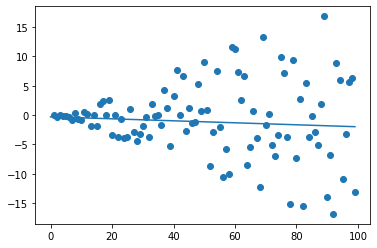

In [20]:
import matplotlib.pyplot as plt

xgbr = XGBRegressor(booster='gblinear')
xgbr.fit(X, y)

plt.scatter(X, y)
plt.plot((0, 99), (xgbr.intercept_, xgbr.coef_*99+xgbr.intercept_))
plt.show()

In [21]:
regression_model(XGBRegressor(booster='gblinear'))

6.214946302686011

In [22]:
regression_model(XGBRegressor(booster='gbtree'))

9.372359516507444

In [23]:
regression_model(LinearRegression())

6.214962315808842

## dart 비교하기

### dart를 사용한 XGBRegressor

In [24]:
X, y = load_diabetes(return_X_y=True)

In [25]:
regression_model(XGBRegressor(booster='dart', rate_drop=0.5))

64.27033739377164

### dart를 사용한 XGBClassifier

In [26]:
df_census = pd.read_csv('https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter08/census_cleaned.csv')
X_census = df_census.iloc[:, :-1]
y_census = df_census.iloc[:, -1]

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

def classification_model(model):
    # 교차 검증 정확도를 계산합니다.
    scores = cross_val_score(model, X_census, y_census, 
                             scoring='accuracy', cv=skf)

    # 평균 값을 반환합니다.
    return scores.mean()

In [28]:
classification_model(XGBClassifier(booster='gbtree'))

0.8711649041738863

In [29]:
classification_model(XGBClassifier(booster='dart', rate_drop=0.1))

0.8702743586725623

In [30]:
classification_model(XGBClassifier(booster='gblinear'))

0.8515094598178431

In [31]:
classification_model(LogisticRegression(max_iter=1000))

0.7959523072547026

### dart 매개변수 적용

In [32]:
classification_model(XGBClassifier(booster='dart', one_drop=1))

0.8728233431077743

In [33]:
regression_model(XGBRegressor(booster='dart', rate_drop=0.5, 
                              sample_type='weighted'))

64.77758988457283

In [34]:
regression_model(XGBRegressor(booster='dart', rate_drop=0.5, 
                              normalize_type='forest'))

63.35922809798802

In [35]:
regression_model(XGBRegressor(booster='dart', one_drop=1))

62.772860826030296

In [36]:
grid_search(params={'rate_drop':[0.01, 0.1, 0.2, 0.4]}, 
            reg=XGBRegressor(booster='dart', one_drop=1))

최상의 매개변수: {'rate_drop': 0.2}
최상의 점수: 61.71159070206184


In [37]:
grid_search(params={'skip_drop': [0.01, 0.1, 0.2, 0.4]}, 
            reg=XGBRegressor(booster='dart', rate_drop=0.2, 
                             one_drop=1))

최상의 매개변수: {'skip_drop': 0.01}
최상의 점수: 62.21768657853914


## XGBoost 랜덤 포레스트

### 랜덤 포레스트 기본 학습기

In [38]:
regression_model(XGBRegressor(booster='gbtree', num_parallel_tree=25))

66.00488961672875

### 스탠드얼론 랜덤 포레스트

In [39]:
regression_model(XGBRFRegressor())

59.506917961367165

In [40]:
regression_model(RandomForestRegressor())

59.46563031802505

In [41]:
classification_model(XGBRFClassifier())

0.855563447853867

In [42]:
classification_model(RandomForestClassifier())

0.8564232761089048